### ATTENTION MECHANISM CON EL DATASET GRANDE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt


In [2]:
# Hiperparámetros
batch_size = 32
lr = 1e-3
epochs = 10
kr = 1e-4  # Regularización L1
drop_prec = 0.25  # Dropout

In [3]:
# Cargar y procesar los datos

def unzip(archivo_zip, variable_name):
    """
    Extrae y carga el contenido del único archivo dentro de un ZIP en una variable global.
    
    Parámetros:
    - archivo_zip: Ruta al archivo ZIP.
    - variable_name: Nombre de la variable global donde se guardará el DataFrame.
    """
    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        # Obtiene directamente el primer (y único) archivo
        file_name = zip_ref.namelist()[0]
        with zip_ref.open(file_name) as txt_file:
            # Leer el archivo como un DataFrame de pandas
            df = pd.read_csv(txt_file, sep='\t', index_col=0)
            
            # Asignar el DataFrame a una variable global con el nombre proporcionado
            builtins.__dict__[variable_name] = df

# paths de descompresión
zip_file_train= '../data/raw/yeast_genotype_train.txt.zip'
zip_file_test = '../data/raw/yeast_genotype_test.txt.zip'

# Llamar a la función para descomprimir y guardar los DataFrames en variables globales
unzip(zip_file_train, 'df_train') 
unzip(zip_file_test, 'df_test')   


In [ ]:

# path de descompresión
zip_file_train= '../data/raw/yeast_genotype_train.txt.zip'
# Llamar a la función para descomprimir y guardar los DataFrames en variable globale
unzip(zip_file_train, 'df_train') 

In [ ]:

df_onehot = tf.keras.utils.to_categorical(df_train)
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

In [4]:

# Dimensiones de entrada
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
input_shape = (feature_size, inChannel)

# Codificador con atención
inputs = Input(shape=input_shape)

In [7]:
# Capas convolucionales del encoder
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)
x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)

# Mecanismo de atención
def attention_1d(inputs):
    # Capa densa para generar los pesos de atención
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Multiplicar las activaciones convolucionales por los pesos de atención
    attention = Multiply()([inputs, attention])
    return attention

# Aplicar la atención después del codificador
x = attention_1d(x)

In [8]:
# Decodificador convolucional
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
outputs = Conv1D(inChannel, 5, activation='softmax', padding='same')(x)


In [9]:
# Definir el modelo
attention_model = Model(inputs, outputs)

In [10]:
# Compilar el modelo
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 32)  │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 500, 32)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 500, 32)   │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 500, 64)   │     10,304 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 250, 64)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 250, 64)   │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 250, 128)  │     41,088 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 250, 128)  │     16,512 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 250, 128)  │          0 │ conv1d_8[0][0],   │
│ (Multiply)          │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 250, 64)   │     41,024 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 500, 64)   │          0 │ conv1d_9[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 500, 32)   │     10,272 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_1     │ (None, 1000, 32)  │          0 │ conv1d_10[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 3)   │        483 │ up_sampling1d_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,195 (469.51 KB)

 Trainable params: 120,195 (469.51 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# Definir DataGenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [13]:

# Entrenamiento
train_generator = DataGenerator(batch_size=batch_size, x_dataset=train_X, missing_perc=0.1)
valid_generator = DataGenerator(batch_size=batch_size, x_dataset=valid_X, missing_perc=0.1)


In [26]:
attention_model_train = attention_model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator
    
)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9370 - loss: 0.1829 - val_accuracy: 0.9445 - val_loss: 0.1688
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9381 - loss: 0.1803 - val_accuracy: 0.9452 - val_loss: 0.1684
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9388 - loss: 0.1781 - val_accuracy: 0.9479 - val_loss: 0.1623
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9393 - loss: 0.1765 - val_accuracy: 0.9484 - val_loss: 0.1619
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9398 - loss: 0.1748 - val_accuracy: 0.9478 - val_loss: 0.1608
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9405 - loss: 0.1741 - val_accuracy: 0.9495 - val_loss: 0.1579
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9412 - loss: 0.1720 - val_accuracy: 0.9500 - val_loss: 0.1565
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9410 - loss: 0.1716 - val_accuracy: 0.9493 - v

### plotting

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_16898/68356141.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")


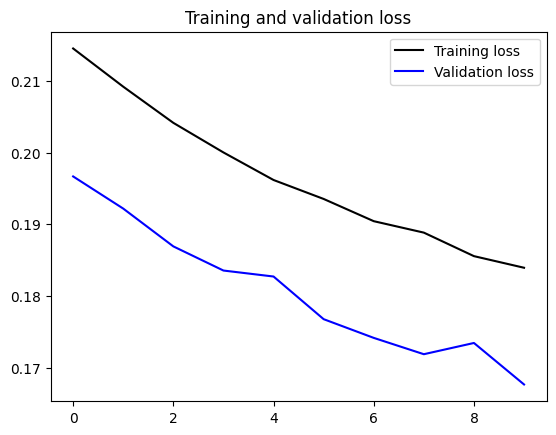

In [24]:
# plot loss curve on validation data
loss = attention_model_train.history['loss']
val_loss = attention_model_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_16898/3295592865.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_16898/3295592865.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")


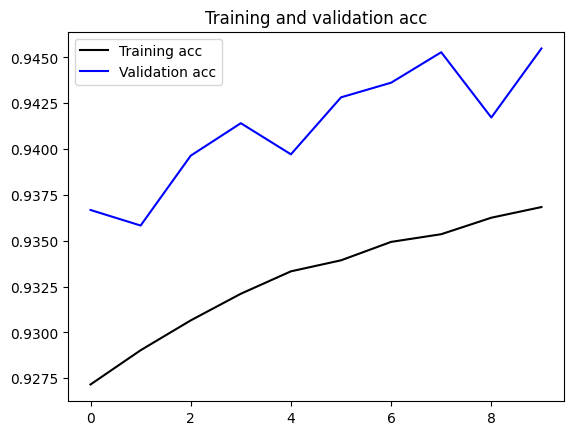

In [25]:
# function modified -- key "acc" did not exist. the correct key is 
# plot accuracy curve on validation data
print(attention_model_train.history.keys())
acc = attention_model_train.history['accuracy'] #initially the key was acc
val_acc = attention_model_train.history['val_accuracy']#initially the key was val_ acc
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [21]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.2198437601327896
Final Validation Loss: 0.20446431636810303
Final Training Accuracy: 0.9257367253303528
Final Validation Accuracy: 0.9347187876701355
